# ANLI - Model Evaluation

This notebook performs comprehensive evaluation:
- Test set performance
- Confusion matrices
- Error analysis
- Performance by text length
- Sample predictions

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import ANLIDataLoader
from models import TransformerNLI
from evaluator import ModelEvaluator

In [2]:
# Load data
loader = ANLIDataLoader()
train_df, dev_df, test_df = loader.load_data()

test_premises, test_hypotheses = loader.prepare_text_pairs(test_df)
test_labels = test_df['label'].values

print(f"Test samples: {len(test_labels)}")

Loading ANLI dataset:
Train size: 45460
Dev size: 1000
Test size: 1000
Test samples: 1000


In [3]:
# Load trained BERT model
print("Loading trained BERT model...")
bert_model = TransformerNLI(model_name='../models/deberta-anli/final', num_labels=3)

Loading trained BERT model...
Using CPU


In [5]:
# Clear memory first
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

# Predict in tiny batches
from tqdm import tqdm
import numpy as np

print("\nMaking predictions in small batches:")

batch_size = 8  # Very small!
all_preds = []

bert_model.model.eval()

for i in tqdm(range(0, len(test_premises), batch_size)):
    batch_premises = test_premises[i:i+batch_size]
    batch_hypotheses = test_hypotheses[i:i+batch_size]

    # Tokenize with shorter max_length
    encodings = bert_model.tokenize_data(
        batch_premises,
        batch_hypotheses,
        max_length=64  # Shorter to save memory
    )

    with torch.no_grad():
        input_ids = encodings['input_ids'].to(bert_model.device)
        attention_mask = encodings['attention_mask'].to(bert_model.device)

        outputs = bert_model.model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy().tolist())

        # Clear after each batch
        del input_ids, attention_mask, outputs, predictions
        torch.cuda.empty_cache()

test_preds = np.array(all_preds)
print("✓ Predictions complete")


Making predictions in small batches:


100%|██████████| 125/125 [03:34<00:00,  1.72s/it]

✓ Predictions complete


## Overall Performance Metrics

In [6]:
print("TEST SET EVALUATION:")

evaluator = ModelEvaluator()
metrics = evaluator.compute_metrics(test_labels, test_preds)

print(f"\nOverall Accuracy: {metrics['accuracy']:.4f}")
print(f"Macro F1-Score: {metrics['macro_f1']:.4f}")

print("\nPer-Class Metrics:")
print("-" * 50)
for label_name, label_metrics in metrics['per_class'].items():
    print(f"\n{label_name.capitalize()}:")
    print(f"  Precision: {label_metrics['precision']:.4f}")
    print(f"  Recall: {label_metrics['recall']:.4f}")
    print(f"  F1-Score: {label_metrics['f1']:.4f}")
    print(f"  Support: {label_metrics['support']}")

TEST SET EVALUATION:

Overall Accuracy: 0.4410
Macro F1-Score: 0.4166

Per-Class Metrics:
--------------------------------------------------

Entailment:
  Precision: 0.4672
  Recall: 0.3413
  F1-Score: 0.3945
  Support: 334

Neutral:
  Precision: 0.4326
  Recall: 0.7417
  F1-Score: 0.5465
  Support: 333

Contradiction:
  Precision: 0.4324
  Recall: 0.2402
  F1-Score: 0.3089
  Support: 333


In [7]:
# Detailed classification report
evaluator.print_classification_report(test_labels, test_preds)


Classification Report:
               precision    recall  f1-score   support

   entailment       0.47      0.34      0.39       334
      neutral       0.43      0.74      0.55       333
contradiction       0.43      0.24      0.31       333

     accuracy                           0.44      1000
    macro avg       0.44      0.44      0.42      1000
 weighted avg       0.44      0.44      0.42      1000



## Confusion Matrix Analysis

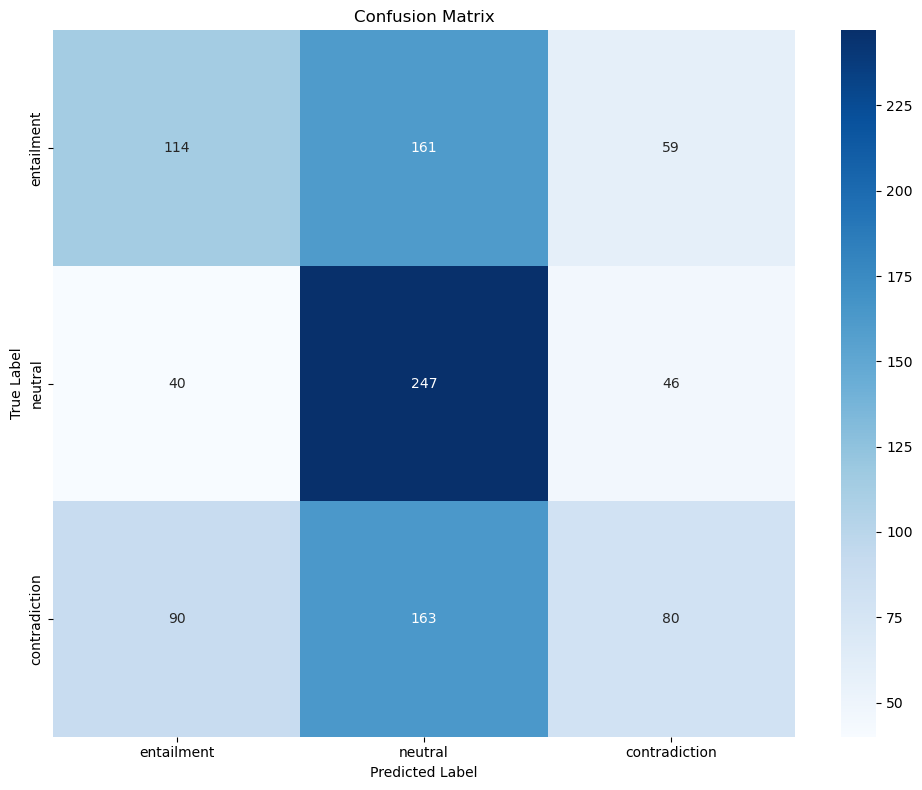

In [8]:
# Regular confusion matrix
evaluator.plot_confusion_matrix(
    test_labels,
    test_preds,
    save_path='../results/plots/confusion_matrix.png',
    normalize=False
)

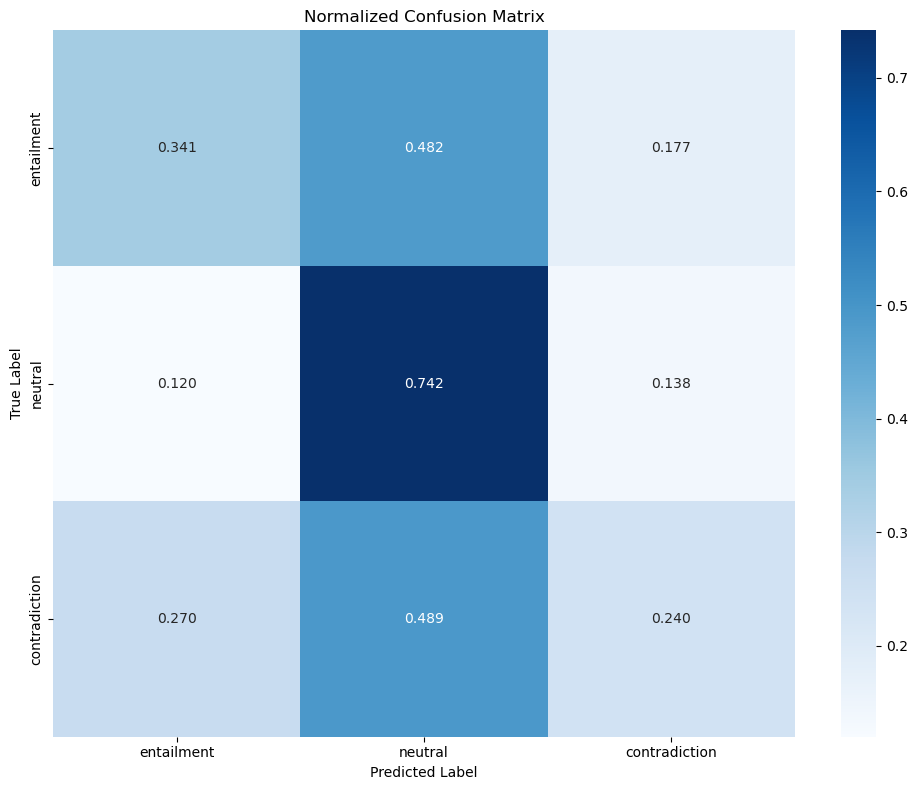

In [9]:
# Normalized confusion matrix
evaluator.plot_confusion_matrix(
    test_labels,
    test_preds,
    save_path='../results/plots/confusion_matrix_normalized.png',
    normalize=True
)

## Error Analysis

In [10]:
errors_df = evaluator.analyze_errors(test_df, test_labels, test_preds)

print(f"\nTotal errors: {len(errors_df)} out of {len(test_labels)}")
print(f"Error rate: {len(errors_df) / len(test_labels):.2%}")

print("\nError patterns:")
print(errors_df['error_type'].value_counts())


Total errors: 559 out of 1000
Error rate: 55.90%

Error patterns:
error_type
contradiction → neutral       163
entailment → neutral          161
contradiction → entailment     90
entailment → contradiction     59
neutral → contradiction        46
neutral → entailment           40
Name: count, dtype: int64


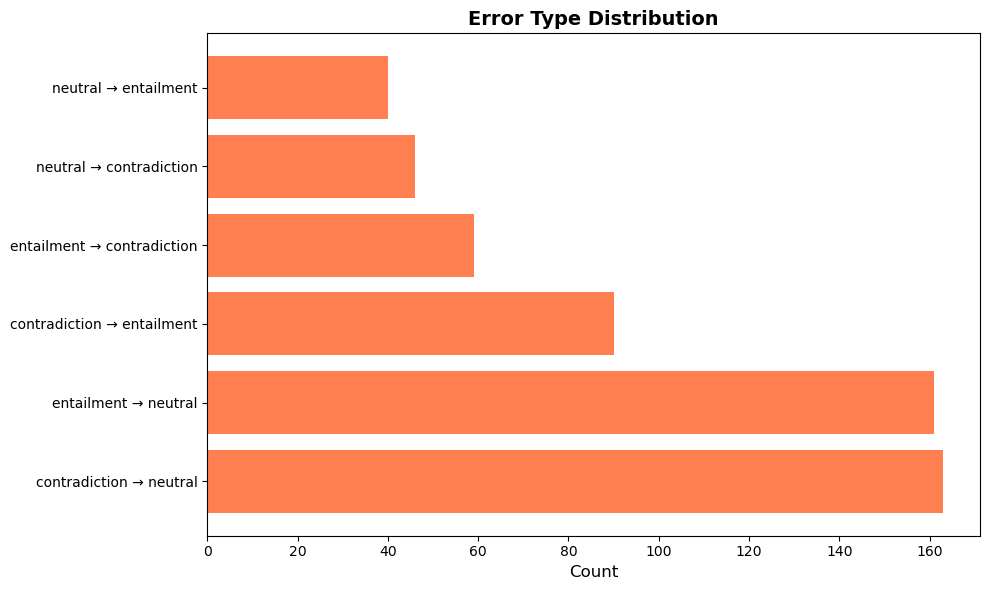

In [11]:
# Visualize error types
error_counts = errors_df['error_type'].value_counts()

plt.figure(figsize=(10, 6))
plt.barh(error_counts.index, error_counts.values, color='coral')
plt.xlabel('Count', fontsize=12)
plt.title('Error Type Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/plots/error_types.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Show example errors
print("SAMPLE ERRORS:")

for error_type in errors_df['error_type'].value_counts().head(3).index:
    print(f"\n{error_type}:")
    print("-" * 50)
    samples = errors_df[errors_df['error_type'] == error_type].head(2)
    for idx, row in samples.iterrows():
        print(f"\nPremise: {row['premise']}")
        print(f"Hypothesis: {row['hypothesis']}")
        print(f"True: {loader.label_map[row['label']]} | Predicted: {loader.label_map[row['predicted']]}")
        print("-" * 50)

SAMPLE ERRORS:

contradiction → neutral:
--------------------------------------------------

Premise: Things Happen at Night is a 1947 British supernatural ghost comedy film directed by Francis Searle and starring Gordon Harker, Alfred Drayton, Robertson Hare and Gwynneth Vaughan. The film is based upon a stage play, "The Poltergeist", by Frank Harvey Jnr.
Hypothesis: Frank Harvey Jnr. wrote Things Happen at Night .
True: contradiction | Predicted: neutral
--------------------------------------------------

Premise: "Beez in the Trap" is a song by rapper Nicki Minaj for her second studio album, "" (2012). It was written by Minaj, Maurice Jordan, and 2 Chainz, who contributed a guest verse to the song, while production was handled by Kenoe. The track was released as the album's third single on May 29, 2012 following "Starships" and "Right by My Side".
Hypothesis: The song was released on the last day of May, 2012
True: contradiction | Predicted: neutral
---------------------------------

## Performance by Text Length

In [13]:
print("PERFORMANCE BY TEXT LENGTH:")

acc_by_premise, acc_by_hypothesis = evaluator.analyze_by_length(test_df, test_labels, test_preds)

print("\nAccuracy by premise length:")
print(acc_by_premise)

print("\nAccuracy by hypothesis length:")
print(acc_by_hypothesis)

PERFORMANCE BY TEXT LENGTH:

Accuracy by premise length:
premise_length
(32.961, 40.8]    0.304348
(40.8, 48.6]      0.463519
(48.6, 56.4]      0.440233
(56.4, 64.2]      0.429553
(64.2, 72.0]      0.454545
Name: correct, dtype: float64

Accuracy by hypothesis length:
hypothesis_length
(2.958, 11.4]    0.486111
(11.4, 19.8]     0.344538
(19.8, 28.2]     0.161290
(28.2, 36.6]     0.300000
(36.6, 45.0]     1.000000
Name: correct, dtype: float64


/Users/vishaknair/Downloads/ANLI1/notebooks/../src/evaluator.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_premise = df_copy.groupby(premise_bins)['correct'].mean()
/Users/vishaknair/Downloads/ANLI1/notebooks/../src/evaluator.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_hypothesis = df_copy.groupby(hypothesis_bins)['correct'].mean()


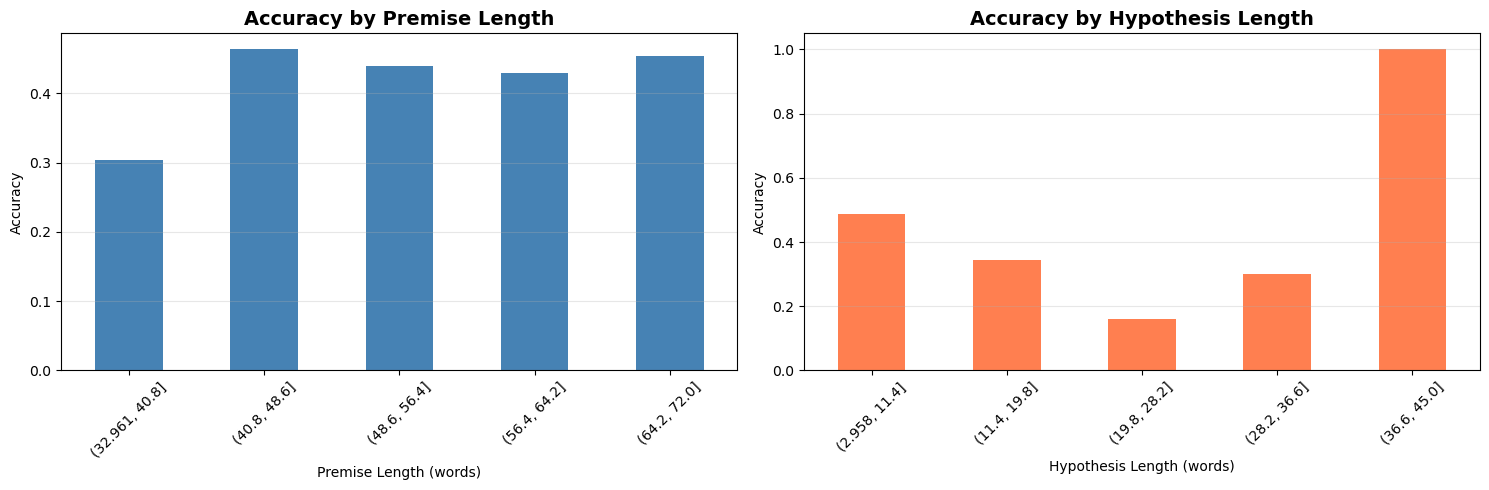

In [14]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

acc_by_premise.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Accuracy by Premise Length', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Premise Length (words)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

acc_by_hypothesis.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Accuracy by Hypothesis Length', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Hypothesis Length (words)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/accuracy_by_length.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Results

In [15]:
# Save metrics
results_summary = {
    'metric': ['Accuracy', 'Macro F1', 'Precision (avg)', 'Recall (avg)'],
    'value': [
        metrics['accuracy'],
        metrics['macro_f1'],
        np.mean([m['precision'] for m in metrics['per_class'].values()]),
        np.mean([m['recall'] for m in metrics['per_class'].values()])
    ]
}

results_df = pd.DataFrame(results_summary)
results_df.to_csv('../results/metrics/test_results.csv', index=False)

print("✓ Test results saved to ../results/metrics/test_results.csv")

✓ Test results saved to ../results/metrics/test_results.csv


In [16]:
# Save detailed predictions
predictions_df = test_df.copy()
predictions_df['predicted_label'] = test_preds
predictions_df['correct'] = test_labels == test_preds
predictions_df.to_csv('../results/metrics/test_predictions.csv', index=False)

print("✓ Detailed predictions saved to ../results/metrics/test_predictions.csv")

✓ Detailed predictions saved to ../results/metrics/test_predictions.csv


In [17]:
print(f"\nFinal Test Accuracy: {metrics['accuracy']:.4f}")
print(f"Final Macro F1: {metrics['macro_f1']:.4f}")
print(f"\nAll results saved to ../results/")


Final Test Accuracy: 0.4410
Final Macro F1: 0.4166

All results saved to ../results/
